In [ ]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from albcovis.utils.img import pil_to_numpy01, rgb_to_gray
import numpy as np

In [ ]:
dir = Path("../data/source/images")
imgs_filenames = [
    "40654268451-px_500.jpg", # 10000Hz Legend
    "14688551481-large.jpg", # MKWAJU
    "9845751214-large.jpg", # Gotan Project
    "22280981189-px_500.jpg", # Dick's Picks Volume Four
    "11446625684-large.jpg", # Carnaval
    "24818281700-px_500.jpg", # Tiger Army Retrofuture
    "39341710398-px_500.jpg", # Xerrox
    "3880053972-px_500.jpg", # Unknown Pleasures
    "24961543145-px_500.jpg", # Hats
    "23776122656-px_500.jpg", # Tre
    "1766939079-large.jpg", # Richest man in babylon
    "17519297659-px_500.jpg", # Amor amarillo
    "4924862361-large.jpg", # The White Album
    "30944412549-px_500.jpg" # Donda
    ] 

# Edge density & Orientation entropy

## Understanding the process of canny edge detection

Using code by Sofiane Sahir as published in an article in Towards Data Science in 2019 ([link](https://medium.com/data-science/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123)).


In [ ]:
import numpy as np
from scipy.ndimage import convolve

# Import slightly adapted functions from reference article to understand steps

def gaussian_kernel(size: int, sigma: float = 1.4) -> np.ndarray:
    half = int(size) // 2
    y, x = np.mgrid[-half:half+1, -half:half+1]
    normal = 1.0 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0 * sigma**2))) * normal
    return g.astype(np.float32)

def sobel_filters(img: np.ndarray):
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=np.float32)
    Ky = np.array([[ 1,  2,  1],
                   [ 0,  0,  0],
                   [-1, -2, -1]], dtype=np.float32)

    Ix = convolve(img, Kx, mode="reflect")
    Iy = convolve(img, Ky, mode="reflect")

    G = np.hypot(Ix, Iy).astype(np.float32)
    G = (G / (G.max() + 1e-8) * 255.0).astype(np.float32)  # match repo scaling
    theta = np.arctan2(Iy, Ix).astype(np.float32)
    return G, theta

def non_max_suppression(mag: np.ndarray, angles: np.ndarray) -> np.ndarray:
    """
    Thin edges by suppressing non-maxima along the local gradient direction.
    Expects:
      - mag: gradient magnitude (float array)
      - angles: gradient orientation in radians, same shape as mag
    Returns:
      - nms: thinned magnitude map (float32), zeros where suppressed
    """

    nms = np.zeros_like(mag, dtype=np.float32)  # output initialized to zero (suppressed everywhere)
    angle = (np.degrees(angles) % 180.0).astype(np.float32)  # convert radians -> degrees and wrap to [0,180)

    H, W = mag.shape  # image size (rows, cols)

    # loop over interior pixels (borders are skipped because they lack two neighbors)
    for i in range(1, H - 1):  # rows 1..H-2
        for j in range(1, W - 1):  # cols 1..W-2
            a = angle[i, j]  # local orientation in degrees
            m = mag[i, j]    # local magnitude

            # pick the two neighbors to compare with, aligned with the quantized direction
            # four bins: 0°, 45°, 90°, 135°
            if (0.0 <= a < 22.5) or (157.5 <= a <= 180.0):
                q = mag[i, j + 1]   # neighbor in +x
                r = mag[i, j - 1]   # neighbor in -x
            elif (22.5 <= a < 67.5):
                q = mag[i + 1, j - 1]  # neighbor at +45° (down-left)
                r = mag[i - 1, j + 1]  # neighbor at -135° (up-right)
            elif (67.5 <= a < 112.5):
                q = mag[i + 1, j]   # neighbor in +y
                r = mag[i - 1, j]   # neighbor in -y
            else:  # (112.5 <= a < 157.5)
                q = mag[i - 1, j - 1]  # neighbor at -45° (up-left)
                r = mag[i + 1, j + 1]  # neighbor at +135° (down-right)

            # keep a pixel only if it is a local maximum along the gradient direction
            if (m >= q) and (m >= r):
                nms[i, j] = m       # keep the magnitude (unsuppressed)
            # else: leave as 0 (suppressed)

    return nms
    
def threshold(img: np.ndarray, lowThresholdRatio: float = 0.05, highThresholdRatio: float = 0.15):
    highThreshold = img.max() * highThresholdRatio
    lowThreshold  = highThreshold * lowThresholdRatio

    res = np.zeros(img.shape, dtype=np.int32)
    weak, strong = np.int32(75), np.int32(255)

    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i,   weak_j   = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i,   weak_j]   = weak
    return res, weak, strong

def hysteresis(img: np.ndarray, weak: int, strong: int = 255) -> np.ndarray:
    M, N = img.shape
    out = img.copy()
    for i in range(1, M-1):
        for j in range(1, N-1):
            if out[i, j] == weak:
                if ((out[i+1, j-1] == strong) or (out[i+1, j] == strong) or (out[i+1, j+1] == strong) or
                    (out[i,   j-1] == strong) or                             (out[i,   j+1] == strong) or
                    (out[i-1, j-1] == strong) or (out[i-1, j] == strong) or (out[i-1, j+1] == strong)):
                    out[i, j] = strong
                else:
                    out[i, j] = 0
    return out

# Loop over somedev_set images to show steps of canny edge detector (raw implementation)
for filename in imgs_filenames[:2]:
    path = dir / filename
    img = Image.open(path)

    # 0) Grayscale
    rgb01 = pil_to_numpy01(img)
    gray01 = rgb_to_gray(rgb01)

    # 1) Gaussian filter (repo-style)
    kernel = gaussian_kernel(size=5, sigma=1.0)         # same defaults as the article
    smoothed = convolve(gray01.astype(np.float32), kernel, mode="reflect")

    # 2) Sobel gradients (repo-style normalization to 0..255)
    mag_255, angles = sobel_filters(smoothed)
    thr = np.percentile(mag_255, 90)
    sobel_edges = mag_255 > thr

    # 3) Non-maximum suppression
    nms = non_max_suppression(mag_255, angles)

    # 4) Double threshold + hysteresis (repo-style, integer labels)
    labels, WEAK, STRONG = threshold(nms, lowThresholdRatio=0.05, highThresholdRatio=0.15)
    final_edges_u8 = hysteresis(labels, WEAK, STRONG)   # values in {0, 75, 255}
    final_edges_bool = (final_edges_u8 == STRONG)       # convenient for overlay/plotting


    # Show
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    ax1,ax2,ax3,ax4,ax5,ax6 = axes.ravel()

    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis("off")

    ax2.imshow(gray01, cmap="gray", vmin=0, vmax=1)
    ax2.set_title("0) Grayscale")
    ax2.axis("off")

    ax3.imshow(smoothed, cmap="gray", vmin=0, vmax=1)
    ax3.set_title("1) Gaussian filter")
    ax3.axis("off")

    ax4.imshow(mag_255, cmap="gray", vmin=0, vmax=255)
    ax4.set_title(f"2) Sobel edges")
    ax4.axis("off")

    ax5.imshow(nms, cmap="gray", vmin=0, vmax=255)
    ax5.set_title("3) Non-maximum suppression")
    ax5.axis("off")

    ax6.imshow(final_edges_bool, cmap="gray")
    ax6.set_title("4) Hysteresis (Final edges)")
    ax6.axis("off")

    plt.tight_layout()
    plt.show()


## Testing different methods to define thresholds

When talking about thresholds for canny algorithm we mean the thresholds used in the hystereis step (final one) to decide the final and definitive edges. These thresholds are used to label pixels as "strong", "weak" or "low" edges. trong edges are definitive edges in the out put of the algorith, weak edges will pass trhough hysteresis step to define them as final edges or not depending on if they are close to strong edges, and low edges are discarded.

So thresholds are in the scale of the magnitude, in this case we use [0,1] scale.

In order to resolve the challenges where it is hard to determine the dual-threshold value empirically, Otsu's method can be used on the non-maximum suppressed gradient magnitude image to generate the high threshold. Some implementations apply it on the raw grayscale intensities, and others normally apply it on the gradient magnitudes array or the gradient magnitude array after non maximum suppresion step in canny algorithm. The challenge is skimage doesn't expose the intermediate arrays of the canny algorithm steps. So to use Otsu to compute thresholds in a **data-driven and empirical** way, we must approximate/mimic the intermediate steps (gaussian filter, sobel operators for magnitudes and orientations and non maximum suppresion). In the original paper by Canny he states guidance to keep a high:low ratio around 2:1 to 3:1, and that is taken into account.

`skimage`'s default is a 0.1 low threshold and 0.2 high threshold. `skimage` can use use quantiles on the gradient magnitudes array.

In [ ]:
from albcovis.utils.img import pil_to_numpy01, rgb_to_gray
from albcovis.services.texture_descriptors import compute_canny_edges, compute_sobel_gradients, compute_edge_density, compute_orientation_entropy_from_sobel
from skimage import feature

from albcovis.services.texture_descriptors import canny_thresholds_otsu_on_gray, canny_thresholds_otsu_on_gradmag, canny_thresholds_otsu_on_nms

# Loop over some dev_set images to show our implementation of canny edge detector for this project

for filename in imgs_filenames:
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    ax1,ax2,ax3,ax4,ax5,ax6 = axes.ravel()

    path = dir / filename
    img = Image.open(path)
    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis("off")


    # prepocess
    rgb01 = pil_to_numpy01(img)
    gray01 = rgb_to_gray(rgb01)

    # otsu on grayscale intensities
    low, high, info = canny_thresholds_otsu_on_gray(gray01)
    edges = feature.canny(gray01, sigma=1.0, low_threshold=low, high_threshold=high)
    ax2.imshow(edges, cmap="gray")
    ax2.set_title(f"otsu on gray01 l={round(low, 4)} h={round(high, 4)}")
    ax2.axis("off")

    # otsu on gradmag
    low, high, info = canny_thresholds_otsu_on_gradmag(gray01)
    edges = feature.canny(gray01, sigma=1.0, low_threshold=low, high_threshold=high)
    ax3.imshow(edges, cmap="gray")
    ax3.set_title(f"otsu on gradmag l={round(low, 4)} h={round(high, 4)}")
    ax3.axis("off")

    # otsu on nms
    low, high, info = canny_thresholds_otsu_on_nms(gray01)
    edges = feature.canny(gray01, sigma=1.0, low_threshold=low, high_threshold=high)
    ax4.imshow(edges, cmap="gray")
    ax4.set_title(f"otsu on nms l={round(low, 4)} h={round(high, 4)}")
    ax4.axis("off")

    # skimage default
    edges = feature.canny(gray01, sigma=1.0, low_threshold=None, high_threshold=None)
    ax5.imshow(edges, cmap="gray")
    ax5.set_title(f"skimage default")
    ax5.axis("off")

    # skimage use quantiles
    edges = feature.canny(gray01, sigma=1.0, low_threshold=0.70, high_threshold=0.90, use_quantiles=True)
    ax6.imshow(edges, cmap="gray")
    ax6.set_title(f"skimage use quantiles")
    ax6.axis("off")

    plt.tight_layout()
    plt.show()

## Testing different sigmas for gaussian filter

In [ ]:
from albcovis.utils.img import pil_to_numpy01, rgb_to_gray
from albcovis.services.texture_descriptors import compute_canny_edges

# Loop over some dev_set images to show our implementation of canny edge detector for this project

for filename in imgs_filenames:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))

    path = dir / filename
    img = Image.open(path)

    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis("off")

    rgb01 = pil_to_numpy01(img)
    gray01 = rgb_to_gray(rgb01)

    sigma = 0.5
    edges = compute_canny_edges(gray01, sigma=sigma)
    ax2.imshow(edges, cmap="gray", vmin=0, vmax=1)
    ax2.set_title(f"Edges canny sigma = {sigma}")
    ax2.axis("off")

    sigma = 1.0
    # low, high, info = canny_thresholds_otsu_on_nms(gray01)
    # edges = feature.canny(gray01, sigma=sigma)
    edges = compute_canny_edges(gray01, sigma=sigma)
    ax3.imshow(edges, cmap="gray", vmin=0, vmax=1)
    ax3.set_title(f"Edges canny sigma = {sigma}")
    ax3.axis("off")

    sigma = 2.0
    edges = compute_canny_edges(gray01, sigma=sigma)
    ax4.imshow(edges, cmap="gray", vmin=0, vmax=1)
    ax4.set_title(f"Edges canny sigma = {sigma}")
    ax4.axis("off")

    plt.tight_layout()
    plt.show()


## Testing our final implementation for metrics

In [ ]:
from albcovis.utils.img import pil_to_numpy01, rgb_to_gray
from albcovis.services.texture_descriptors import compute_canny_edges, compute_sobel_gradients, compute_edge_density, compute_orientation_entropy_from_sobel

# Loop over some dev_set images to show our implementation of canny edge detector for this project

for filename in imgs_filenames:
    path = dir / filename
    img = Image.open(path)

    rgb01 = pil_to_numpy01(img)
    gray01 = rgb_to_gray(rgb01)

    # 2) Canny edges
    edges = compute_canny_edges(gray01, sigma=0.75)
    ed = compute_edge_density(edges)

    # 3) Sobel orientation entropy
    gx, gy, mag = compute_sobel_gradients(gray01)
    oe = compute_orientation_entropy_from_sobel(gx, gy, mag, nbins=18)

    # Show
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis("off")

    ax2.imshow(edges, cmap="gray", vmin=0, vmax=1)
    ax2.set_title("Edges")
    ax2.axis("off")

    ax3.imshow(gray01, cmap="gray", vmin=0, vmax=1)
    ax3.contour(edges, levels=[0.5], linewidths=0.8)
    ax3.set_title("Edges overlaid on image")
    ax3.axis("off")

    plt.tight_layout()
    plt.show()

    print(filename)
    print(f"edge_density: {ed}")
    print(f"edge_orientation_entropy: {oe}")


# Pixel intensity entropy

> ¿Porqué usar shannon entropy y no usar varianza o dev. estándar?

In [ ]:
from albcovis.services.texture_descriptors import compute_entropy_gray

In [ ]:
for filename in imgs_filenames:
    path = dir / filename
    img = Image.open(path)
    rgb01 = pil_to_numpy01(img)
    gray01 = rgb_to_gray(rgb01)
    nbins = 256
    entropy_val = compute_entropy_gray(gray01, nbins=nbins)
    hist, bin_edges = np.histogram(gray01, bins=nbins, range=(0.0, 1.0))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis("off")

    ax2.imshow(gray01, cmap="gray", vmin=0, vmax=1)
    ax2.set_title("Grayscale")
    ax2.axis("off")
    
    ax3.bar(bin_edges[:-1], hist, width=1/256, color="gray", edgecolor="black")
    ax3.set_title("Pixel Intensity Histogram")
    ax3.set_xlabel("Pixel intensity (0=black, 1=white)")
    ax3.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    print(filename)
    print(f"entropy_val: {entropy_val}")

# GLCM Features (Haralick descriptors)

In [ ]:
from albcovis.services.texture_descriptors import compute_glcm_features

In [ ]:
filename = imgs_filenames[0]
path = dir / filename
img = Image.open(path)
rgb01 = pil_to_numpy01(img)
gray01 = rgb_to_gray(rgb01)
feats = compute_glcm_features(gray01)
feats

In [ ]:
# Columns to show
desc_cols = ["glcm_contrast", "glcm_homogeneity", "glcm_energy", "glcm_correlation", "glcm_entropy"]

# Pass 1: compute features and keep grayscale display images
rows = []
for filename in imgs_filenames:
    path = dir / filename
    img = Image.open(path)

    # user-provided starting lines
    rgb01  = pil_to_numpy01(img)     # float image in [0,1], shape (H,W,3)
    gray01 = rgb_to_gray(rgb01)      # float image in [0,1], shape (H,W)

    feats = compute_glcm_features(gray01)  # all values already in [0,1]
    rows.append({
        "filename": str(filename),
        "gray01": gray01,
        **feats
    })

# Everyone shares the same x-limits now
xlims = {d: (0.0, 1.0) for d in desc_cols}

# Plot: each row = image, then one small bar-plot per descriptor
n_rows = len(rows)
n_cols = 1 + len(desc_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.0 * n_cols, 2.6 * n_rows), squeeze=False)

# Column headers
axes[0, 0].set_title("Image", fontsize=11)
for j, d in enumerate(desc_cols, start=1):
    axes[0, j].set_title(d.replace("glcm_", ""), fontsize=11)

for i, r in enumerate(rows):
    # image cell
    ax_img = axes[i, 0]
    ax_img.imshow(np.clip(r["gray01"], 0, 1), cmap="gray")
    ax_img.set_axis_off()
    ax_img.set_xlabel(r["filename"], fontsize=9)

    # descriptor cells (single horizontal bar + value)
    for j, d in enumerate(desc_cols, start=1):
        ax = axes[i, j]
        v = float(np.clip(r[d], 0.0, 1.0))   # safety clip
        ax.barh([0], [v], height=0.6)
        ax.set_xlim(0.0, 1.0)
        ax.set_yticks([])
        ax.grid(True, axis='x', linestyle=':', alpha=0.4)
        ax.tick_params(axis='x', labelsize=8)
        ax.text(v, 0, f" {v:.4f}", va='center', ha='left', fontsize=9)
        for spine in ["top", "right", "left"]:
            ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


# Local Binary Patterns

In [ ]:
from albcovis.services.texture_descriptors import compute_lbp_features

In [ ]:
for filename in imgs_filenames:
    path = dir / filename
    img = Image.open(path)
    rgb01 = pil_to_numpy01(img)
    gray01 = rgb_to_gray(rgb01)

    P = 8
    R = 1.0

    lbp = feature.local_binary_pattern(gray01, P=P, R=R, method="uniform")
    lbp_features = compute_lbp_features(gray01, P=P, R=R)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis("off")

    ax2.imshow(lbp, cmap="gray", vmin=0, vmax=1)
    ax2.set_title("LBP")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

    print(filename)
    print(lbp_features)

# Visual complexity final metric

In [1]:
from albcovis.services.texture_descriptors import extract_visual_complexity
from albcovis.utils.img import pil_to_numpy01, rgb_to_gray, limit_image_size


from PIL import Image
from pathlib import Path

In [2]:
SRC_DIR = Path("../data/source/images")
exts = (".png", ".jpg", ".jpeg", ".webp", ".bmp")
files = sorted([p for p in SRC_DIR.iterdir() if p.suffix.lower() in exts])

if not files:
    print(f"No images found in: {SRC_DIR.resolve()}")
else:
    print(f"Found {len(files)} images in: {SRC_DIR.resolve()}")

# vcs = []
# for path in files:
#     img = Image.open(path)
#     img = limit_image_size(img)
#     rgb01 = pil_to_numpy01(img)
#     gray01 = rgb_to_gray(rgb01)

#     visual_complexity = extract_visual_complexity(gray01)
#     vcs.append(visual_complexity["visual_complexity"])

rows = []

for path in files:
    try:
        img = Image.open(path)
        img = limit_image_size(img)
        rgb01 = pil_to_numpy01(img)
        gray01 = rgb_to_gray(rgb01)

        vc = extract_visual_complexity(gray01)
        desc = vc.get("texture_descriptors", {})

        row = {
            "file": str(path),
            "visual_complexity": vc.get("visual_complexity", None),
        }
        row.update(desc)  # flatten texture descriptor metrics into the row
        rows.append(row)

    except Exception as e:
        print(f"Skipping {path}: {e}")

Found 140 images in: /home/sge/Documents/Sergio's OV [Debian]/Esade MiBA/TFM/albcovis-project/data/source/images


/home/sge/Documents/Sergio's OV [Debian]/Esade MiBA/TFM/albcovis-project/.venv/lib/python3.11/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [3]:
import pandas as pd

# Build the DataFrame with all metrics
df = pd.DataFrame(rows)

# Optional: put columns in a nice order if present
metric_cols = [
    "visual_complexity",
    "edge_density",
    "orientation_entropy",
    "pixel_intensity_entropy",
    "glcm_contrast",
    "glcm_homogeneity",
    "glcm_energy",
    "glcm_correlation",
    "glcm_entropy",
    "lbp_entropy",
    "lbp_energy",
]
cols = ["file"] + [c for c in metric_cols if c in df.columns]
df = df[cols]

# Summary of distributions (all metrics are in [0, 1]), transposed
summary_T = df.drop(columns=["file"]).describe().T
summary_T

count      mean       std       min       25%  \
visual_complexity        140.0  0.622916  0.127537  0.000000  0.588252   
edge_density             140.0  0.067055  0.044452  0.000000  0.035354   
orientation_entropy      140.0  0.923377  0.111099  0.000000  0.907171   
pixel_intensity_entropy  140.0  0.778894  0.194303 -0.000000  0.701986   
glcm_contrast            140.0  0.011529  0.009090  0.000000  0.005938   
glcm_homogeneity         140.0  0.688649  0.129742  0.380728  0.600450   
glcm_energy              140.0  0.295435  0.200429  0.077816  0.151770   
glcm_correlation         140.0  0.937988  0.046564  0.762097  0.922146   
glcm_entropy             140.0  0.566108  0.173421  0.000000  0.463848   
lbp_entropy              140.0  0.903227  0.170859 -0.000000  0.914023   
lbp_energy               140.0  0.167918  0.155540  0.106225  0.111614   

                              50%       75%       max  
visual_complexity        0.664572  0.697538  0.759623  
edge_density             0.058403  0.093606  0.242442  
orientation_entropy      0.958579  0.980140  0.998269  
pixel_intensity_entropy  0.852043  0.907014  0.987596  
glcm_contrast            0.009157  0.015083  0.056445  
glcm_homogeneity         0.683589  0.773001  1.000000  
glcm_energy              0.215807  0.388432  1.000000  
glcm_correlation         0.951398  0.967893  1.000000  
glcm_entropy             0.618765  0.694664  0.821049  
lbp_entropy              0.958164  0.975398  0.987385  
lbp_energy               0.119608  0.142944  1.000000

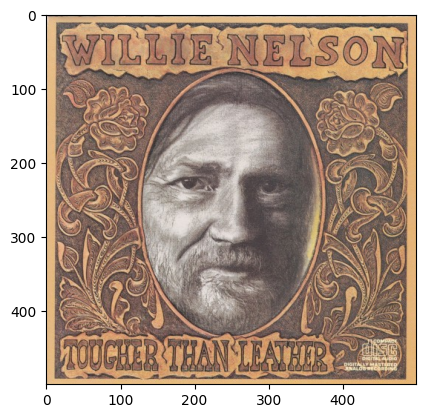

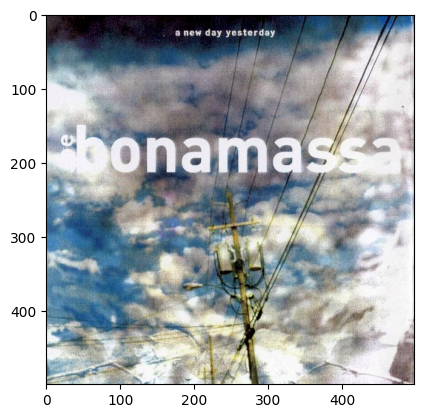

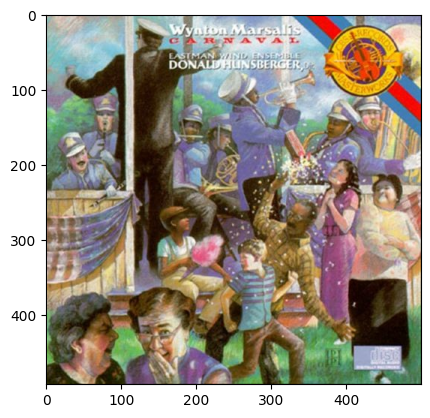

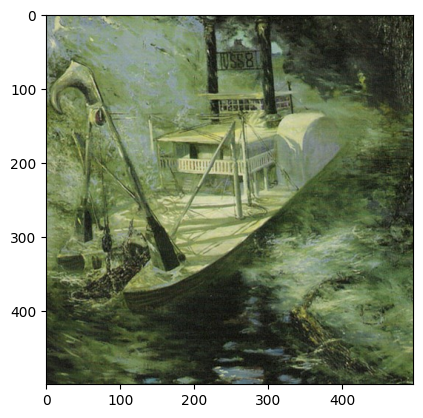

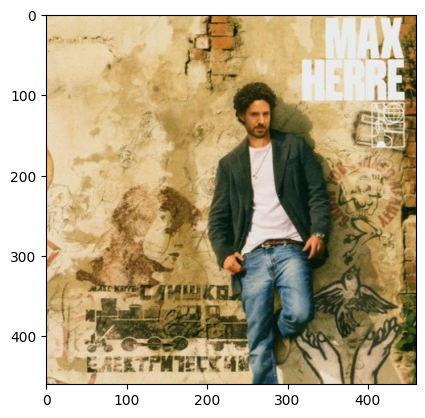

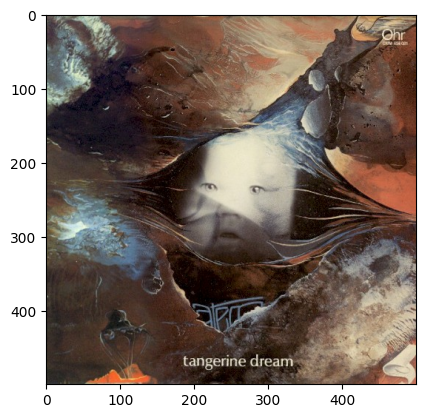

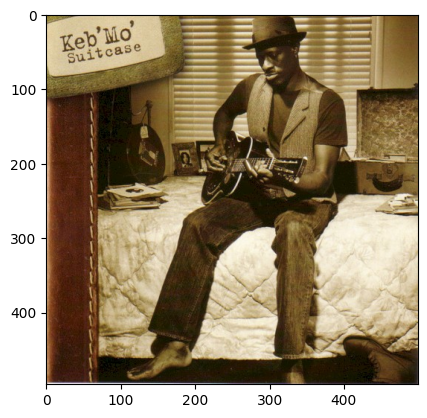

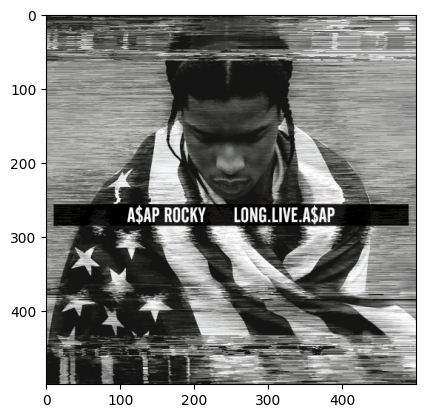

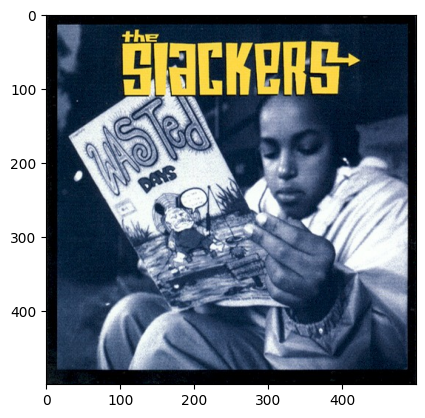

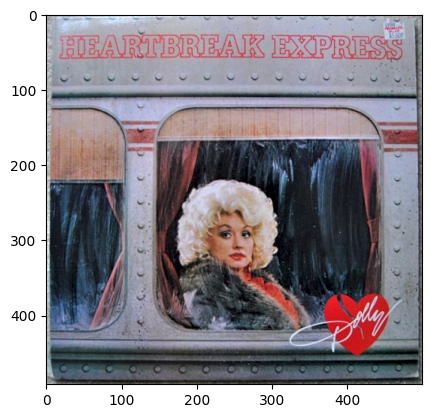

In [4]:
import matplotlib.pyplot as plt

for file in list(df.sort_values("visual_complexity", ascending=False)["file"])[:10]:
    img = Image.open(file)
    plt.imshow(img)
    plt.show()

In [5]:
corr = df.drop(columns=["file"]).corr(numeric_only=True)
corr.to_csv("temp.csv")

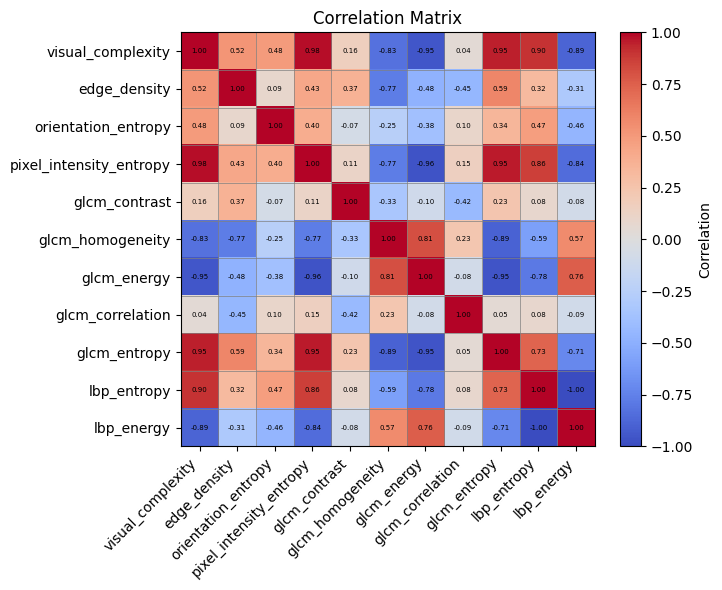

In [6]:
import matplotlib.pyplot as plt
import numpy as np

corr = df.drop(columns=["file"]).corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the heatmap
cax = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)

# Add colorbar
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04, label="Correlation")

# Set ticks and labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.columns)

# Add grid lines
ax.set_xticks(np.arange(-.5, len(corr.columns), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(corr.columns), 1), minor=True)
ax.grid(which="minor", color="gray", linestyle="-", linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha="center", va="center", color="black", fontsize=5)


plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


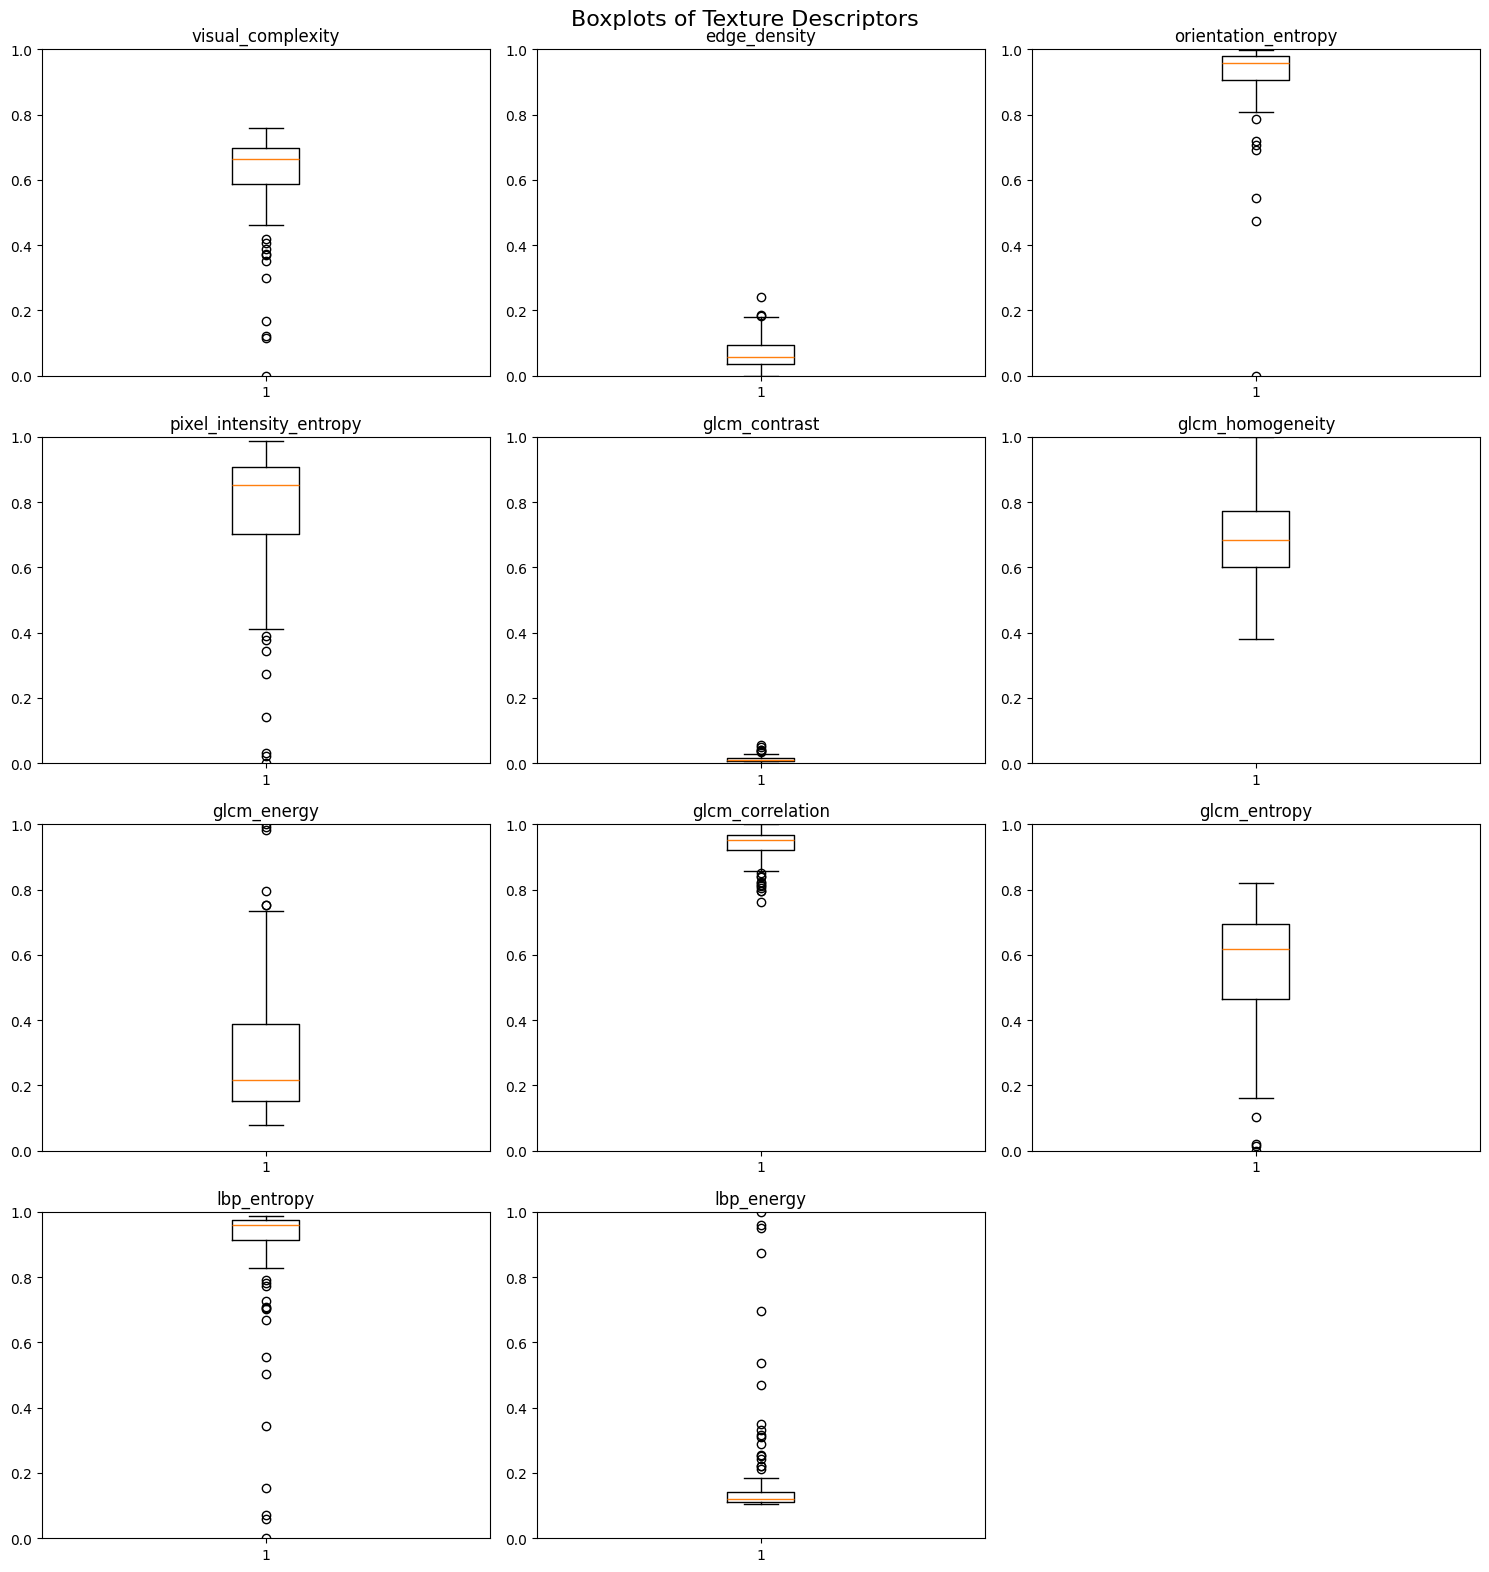

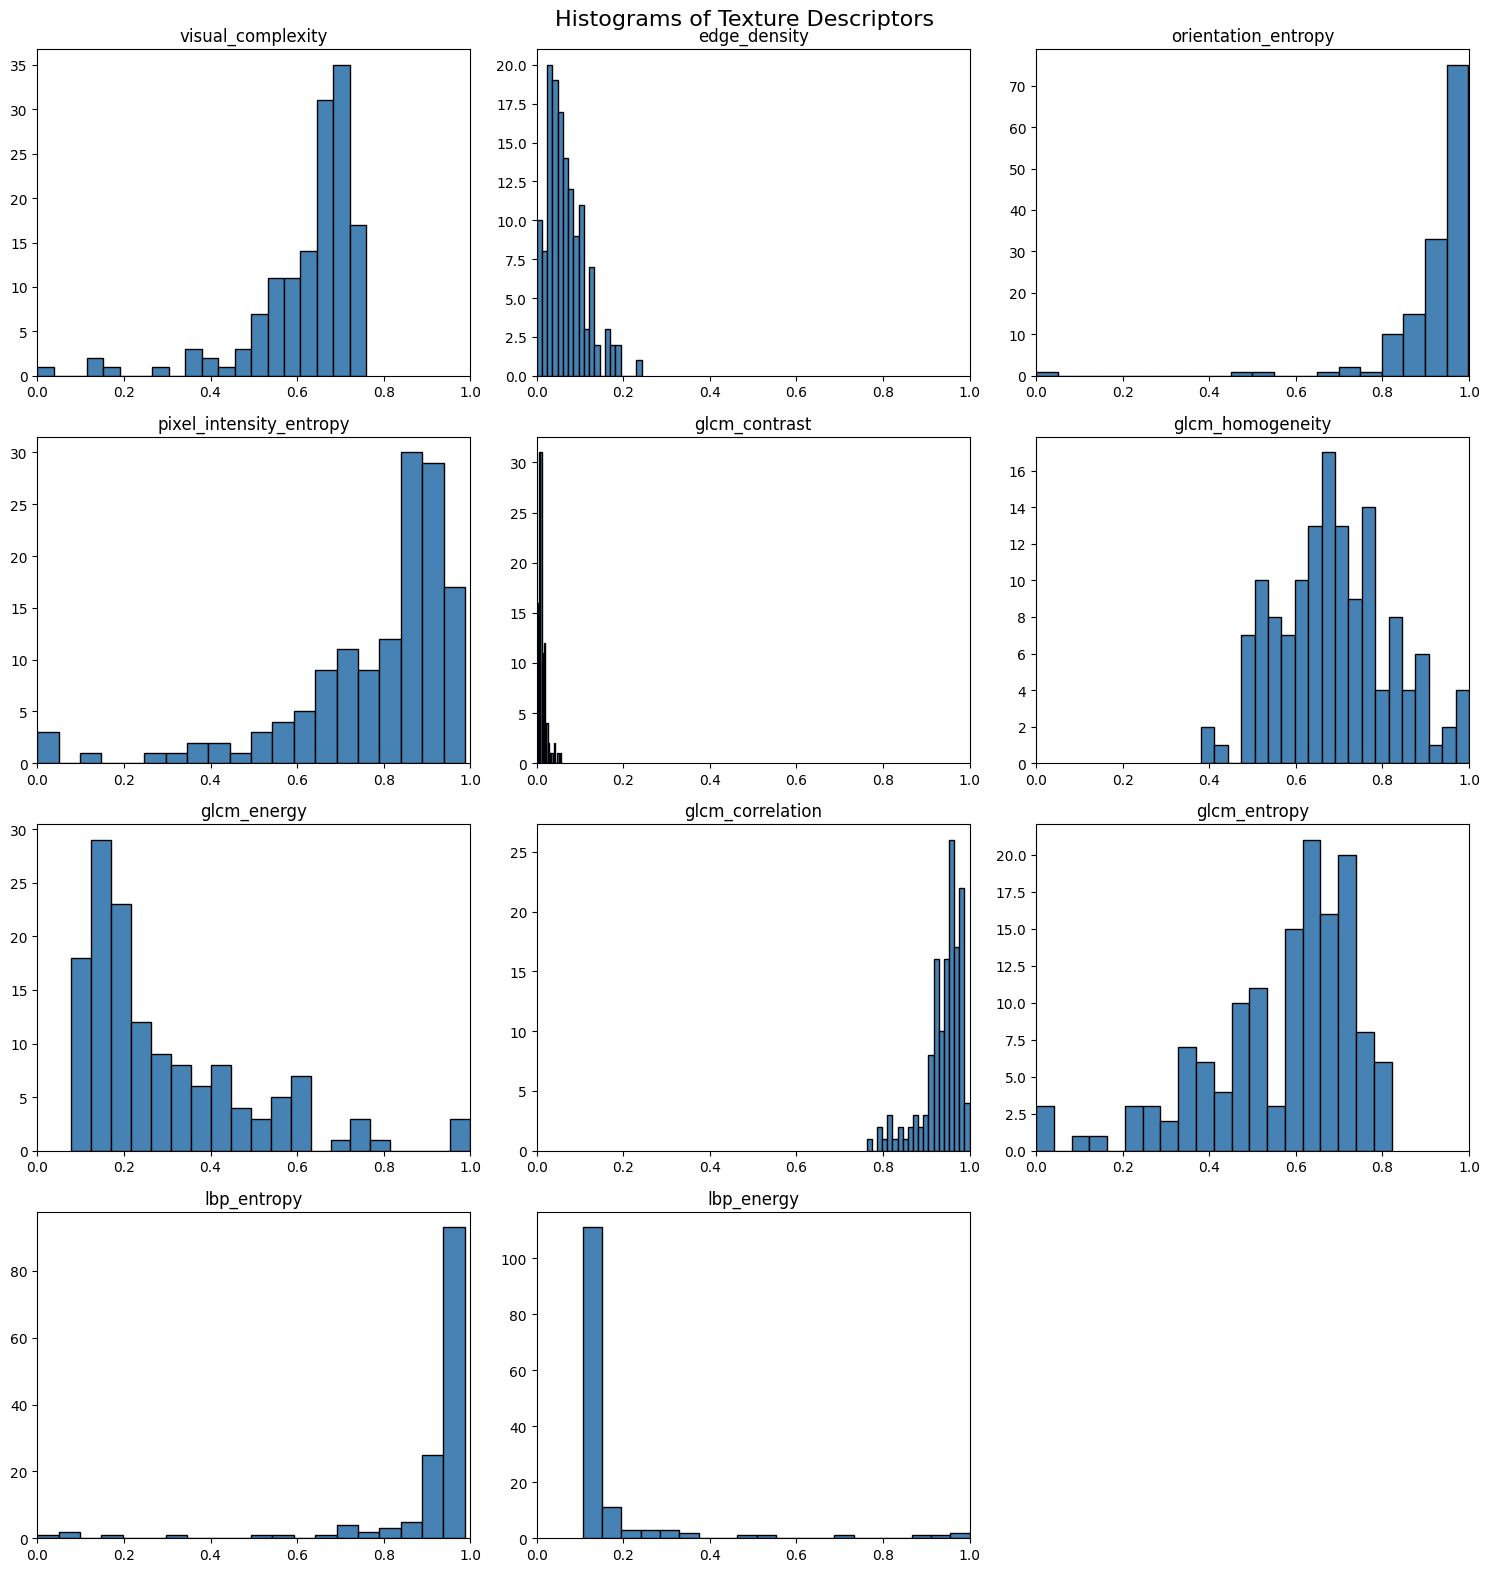

In [7]:
import matplotlib.pyplot as plt

# Drop non-numeric columns like "file"
metrics = df.drop(columns=["file"])

# --- Boxplots ---
n_cols = 3  # number of subplots per row
n_metrics = len(metrics.columns)
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(metrics.columns):
    axes[i].boxplot(metrics[col].dropna(), vert=True)
    axes[i].set_title(col)
    axes[i].set_ylim(0, 1)  # since all values are in [0,1]

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Boxplots of Texture Descriptors", fontsize=16)
plt.tight_layout()
plt.show()


# --- Histograms ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(metrics.columns):
    axes[i].hist(metrics[col].dropna(), bins=20, color="steelblue", edgecolor="black")
    axes[i].set_title(col)
    axes[i].set_xlim(0, 1)  # same range for comparison

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Histograms of Texture Descriptors", fontsize=16)
plt.tight_layout()
plt.show()
